## Cross correlations importance

In [1]:
# Import stuff
import numpy as np 
import scipy
from scipy.special import erf
from scipy import interpolate 
from scipy.interpolate import UnivariateSpline
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
from scipy.special import gamma
import pylab as pl
from code.plot_utils import plot_pretty
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#==============================================================================#
#==============================================================================#
#
#
# # Now create a class that can create CAMB cosmologies for different matter densities and sigma_8
class Cosmology:
    
    def __init__(self,omega_m,sigma_8,h,z):
        self.omega_m = omega_m
        self.sigma_8 = sigma_8
        self.h = h
        self.z = z
        self.k_max = 10.0
        self.c = 2.99792e+5
        
        
        #=========================
        
        
        cosmo = camb.CAMBparams()
        cosmo.set_cosmology(H0=100.0*self.h, ombh2=0.048*(self.h**2.0), omch2=(self.omega_m - 0.048)*(self.h**2.0), mnu=0.06, omk=0, tau=0.06)
        cosmo.InitPower.set_params(As=2.0e-9, ns=0.973)
        results = camb.get_results(cosmo)
        cosmo.set_matter_power(redshifts=[0.0], kmax=10.0)
        cambres= camb.get_transfer_functions(cosmo)
        cosmo.NonLinear = model.NonLinear_both
        kh, z, pk = cambres.get_matter_power_spectrum(minkh=1e-3, maxkh=1.0, npoints = 10)
        sigma_8_temp = cambres.get_sigma8()
        As_new  = ((self.sigma_8/sigma_8_temp)**2.0)*(2.0e-9)
        cosmo.InitPower.set_params(As=As_new, ns=0.973)
        cambres = camb.get_results(cosmo)
        backres = camb.get_background(cosmo)

        self.chi = backres.comoving_radial_distance(self.z)
           
        self.PK = camb.get_matter_power_interpolator(cosmo, nonlinear=True, 
                hubble_units=False, k_hunit=False, kmax=self.k_max, zmin = 0.0, zmax=self.z[-1]) 
        
        self.H_z = (backres.hubble_parameter(self.z))/self.c #Hubble parameter in 1/Mpc 
        
        
#===================================================================================================================
#===================================================================================================================

# Selecting cosmologies

# Instantize cosmologies 

omega_m = 0.301
sigma_8 = 0.798
h = 0.682
alpha_om  = omega_m/10.0
alpha_sig = sigma_8/10.0

#==========================
nz = 1000 #number of steps to use for the radial/redshift integration

zarray = np.linspace(0,3.0,nz)
z = zarray[1:-1]

cosmo_fid = Cosmology(omega_m, sigma_8, h, z)
cosmo_1 = Cosmology(omega_m + alpha_om, sigma_8, h, z)
cosmo_2 = Cosmology(omega_m - alpha_om, sigma_8, h, z)
cosmo_3 = Cosmology(omega_m, sigma_8 + alpha_sig, h, z)
cosmo_4 = Cosmology(omega_m, sigma_8 - alpha_sig, h, z)

#=================================================================================================================#
#=================================================================================================================#

def cosmoselector(omega, sigma):
    #function that selects cosmology
    
    omfid = 0.301
    sigfid = 0.798
    
    cosmo_dict = {'cosmo_fid': cosmo_fid,
                  'cosmo_1' : cosmo_1,
                  'cosmo_2' : cosmo_2,
                  'cosmo_3' : cosmo_3,
                  'cosmo_4' : cosmo_4}
    
    
    if (omega==omfid):
        if (sigma == sigfid):
            cosm_sel = cosmo_dict['cosmo_fid']
        elif (sigma > sigfid):
            cosm_sel = cosmo_dict['cosmo_3']
        else:
            cosm_sel = cosmo_dict['cosmo_4']
    elif (omega > omfid): 
        cosm_sel = cosmo_dict['cosmo_1']
    else:
        cosm_sel = cosmo_dict['cosmo_2']
        
    
    return cosm_sel

# =============================================================================================================#
# =============================================================================================================#

# Function that calculates and returns window function W(z) for clustering in a bin i

def W_z_clust(z, dz, z_i, z_f, sig_z, z_b, b_g, z_0, a, b ):
    """
    Function that calculates the window function for 2D galaxy clustering in a bin i
    -----------------
    Inputs:
    z: array of redshifts used to calculate the window function
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error spread
    z_b : redshift bias in a bin i 
    b_g : galaxy bias in a bin i
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    The window function and its integral over all redshifts for a given bin with given limits
    
    """
    
    # Overall redshift distribution
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    
    # Photometric window function
    x_min = (z - z_i - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f - z_b)/((1.0+z)*sig_z*np.sqrt(2.0))

    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Normalization
    norm_const = np.dot(dz, dNdz*F_z)
    
    # Window function 
    
    W_z_bin = b_g*dNdz*F_z/norm_const
    
    return W_z_bin, norm_const

In [3]:
# Function that calculates C_l,ij  - the cross angular spectum between two bins

def C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, sig_z, z_b_1, z_b_2, b_g_1, b_g_2, Omega_m, sig_8, z_0, a, b, ell):
    """
    Function that calculates the C_l between two bins 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first bin
    z_f_1 : Upper limit of the first bin
    z_i_2 : Lower limit of the second bin
    z_f_2 : Upper limit of the second bin
    sig_z : photo-z error scatter
    z_b_1 : photo-z bias of the first bin
    z_b_2 : photo-z bias of the second bin
    b_g_1 : galaxy bias of the first bin
    b_g_2 : galaxy bias of the second bin
    Omega_m_var: Omega matter - can change
    sig_8_var : Sigma_8 parameter - can change
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    ls and C_l betwenn two bins, i and j. It is the auto spectrum if i=j
    """
    
    # Constant
    h = 0.682
    c = 2.99792e+5

    #====================================================================================
    #====================================================================================
    # Selecting cosmology
    
    cosmo = cosmoselector(Omega_m, sig_8)
    
    #====================================================================================
    #====================================================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,3.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #====================================================================================
    #Calculate the window function in the two bins
    
    W_1 = W_z_clust(zarray, dzarray, z_i_1, z_f_1, sig_z, z_b_1, b_g_1, z_0, a, b)[0]
    W_2 = W_z_clust(zarray, dzarray, z_i_2, z_f_2, sig_z, z_b_2, b_g_2, z_0, a, b)[0]
    
    #===================================================================================
    #Calculate Hubble parameter and comoving distance
    Hubble = cosmo.H_z
    # Get comoving distance - in Mpc
    chis = cosmo.chi
    #========================================================
    # Get the full prefactor of the integral
    prefact = W_1*W_2*Hubble/(chis**2.0)
    #===================================================================================
    #===================================================================================
    #Do integral over z
    
    w = np.ones(chis.shape)
    k=(ell+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    c_ell = np.dot(dzarray, w*cosmo.PK.P(zarray, k, grid=False)*prefact)
    
    #===========================
    # Retrurn C_ell
    
    return c_ell   

In [4]:
def C_l_matr(z_init, z_end, N_bins, sig_z, z_0, a, b, ell):
    """
    Function that caclulates and returns a matrix that has elements C_l^{ij} for a given l
    ==============================================================
    Inputs:
    
    z_init : initial redshift of the distribution
    z_end  : final redshift of the distribution
    l      : multipole for which we calculate the matrix
    N_bins : number of redshift bins
    sig_z  : redshift error
    n_tot  : total angular density of objects
    z_0    : mean redshift of the distribution
    
    Returns:
    
    The matrix C_l^{ij}
    
    """
    Omega_m = 0.301
    sigma_8 = 0.798
    z_b = 0.0
    #=============================================================
    #Redshift range for calculations and integration
    nz = 1000 #number of steps to use for the radial/redshift integration

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    #==================================================================
    #In this module, find the redshift limits of the bins
    
    delta_z = (z_end - z_init)/N_bins # Width of each bin
    
    z_lims = np.zeros(N_bins+1) #An empty array that will contain the upper and lower limits of the bins
                                #The number of limits is equals the number of bins plus one
    
    # Now populate the array of the redshift limits
    for i in range (0,N_bins+1):
        z_lims[i] = z_init + i*delta_z
    
    #===================================================================
    # Here we calculate the bias factors
    bias = np.zeros(N_bins) #Create an array that will be populated by the bias factors
                            #Its size is the same as the number of bins
        
    #Now populate the array of galaxy biases
    
    for i in range(N_bins):
        bias[i] = 1.0 + 0.5*(z_lims[i]+z_lims[i+1])
    
    #===================================================================
    # Create matrix which contains the elements C_l^ij
    
    #Initialize 
    
    C_l_matr = np.zeros([N_bins,N_bins])  #Contains C_ell's
    
    sum_auto = 0.0
    sum_cross = 0.0
    
    for i in range(0,N_bins):
        # Now we have to calculate the limits of the two bins
        #Limits of the first -i- bin
        z_in_i = z_lims[i]
        z_fin_i = z_lims[i+1]
        b_g_i = bias[i]
        for j in range(i,N_bins):
            #Limits of the second -j-bin
            z_in_j = z_lims[j]
            z_fin_j = z_lims[j+1]
            b_g_j = bias[j]
            #======================================================
            if (i==j):
                C_l_matr[i,i] = C_l_ij(z_in_i,z_fin_i,z_in_i,z_fin_i, sig_z, z_b, z_b, b_g_i, b_g_i, Omega_m , sigma_8, z_0, a, b, ell) 
                sum_auto += C_l_matr[i,i]
            else: 
                C_l_matr[i,j] = C_l_matr[j,i] = C_l_ij(z_in_i,z_fin_i,z_in_j,z_fin_j, sig_z, z_b, z_b, b_g_i, b_g_j, Omega_m, sigma_8, z_0, a, b, ell)
                sum_cross += C_l_matr[i,j]
    
    
    return sum_auto, sum_cross, C_l_matr

In [5]:
z_init = 0.2
z_end = 0.95
N_bins = 5
sig_z_fl = 0.073
sig_z_rm = 0.017
z_0 = 0.50
a = 1.47
b = 1.48
ell = 200

sum_a_fl, sum_c_fl, C_mat_fl = C_l_matr(z_init, z_end, N_bins, sig_z_fl, z_0, a, b, ell)
sum_a_rm, sum_c_rm, C_mat_rm = C_l_matr(z_init, z_end, N_bins, sig_z_rm, z_0, a, b, ell)

In [6]:
import seaborn as sns
import matplotlib.axis as ax

from matplotlib import rcParams
rcParams['font.family'] = 'serif' 

plot_pretty()

In [7]:
N_gal_rm = 2.43e6 
N_gal_fl = 6.75e7

def n_bin_dens(z_init, z_final, N_bins, N_gal_tot, sig_z, f_sky, z_0, a, b):
    delta_z = (z_final - z_init)/N_bins # Width of each bin

    z_lims = np.zeros(N_bins+1) #An empty array that will contain the upper and lower limits of the bins
                                #The number of limits is equals the number of bins plus one
    
    # Now populate the array of the redshift limits
    for i in range (0,N_bins+1):
        z_lims[i] = z_init + i*delta_z

    #=========================================================================
    #=============================================================
    #Redshift range for calculations and integration
    nz = 1000 #number of steps to use for the radial/redshift integration

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    
    z_bias = 0.0
    bias = 1.0

    # Find normalizations 
    # This array containts the normalizations - or the integrals of the bins

    norm_of_bins = np.zeros(N_bins)

    # Populate them

    for i in range(0,N_bins):
        z_i_bin = z_lims[i]
        z_f_bin = z_lims[i+1]

        norm_of_bins[i] = W_z_clust(zarray, dzarray, z_i_bin, z_f_bin, sig_z, z_bias, bias, z_0, a, b)[1]
        
    # Overall normalization

    tot_norm = np.sum(norm_of_bins)
    
    N_gal_in_bins = (N_gal_tot/tot_norm)*norm_of_bins
    
    ster = f_sky*(4.0*np.pi)
    n_bin = N_gal_in_bins/ster
    
    return n_bin


f_sky = 5000./41253.0 # Fraction of the sky
n_bin_rm = n_bin_dens(z_init, z_end, N_bins, N_gal_rm, sig_z_rm, f_sky, z_0, a, b)
n_bin_fl = n_bin_dens(z_init, z_end, N_bins, N_gal_fl, sig_z_fl, f_sky, z_0, a, b)



#for i in range(len(n_bin_rm)):
#    n_b_rm = n_bin_rm[i]
#    n_b_fl = n_bin_fl[i]
    
#    C_mat_fl[i,i] = C_mat_fl[i,i] + 1.0/(n_b_fl)
#    C_mat_rm[i,i] = C_mat_rm[i,i] + 1.0/(n_b_rm)
    

### Flux limited first

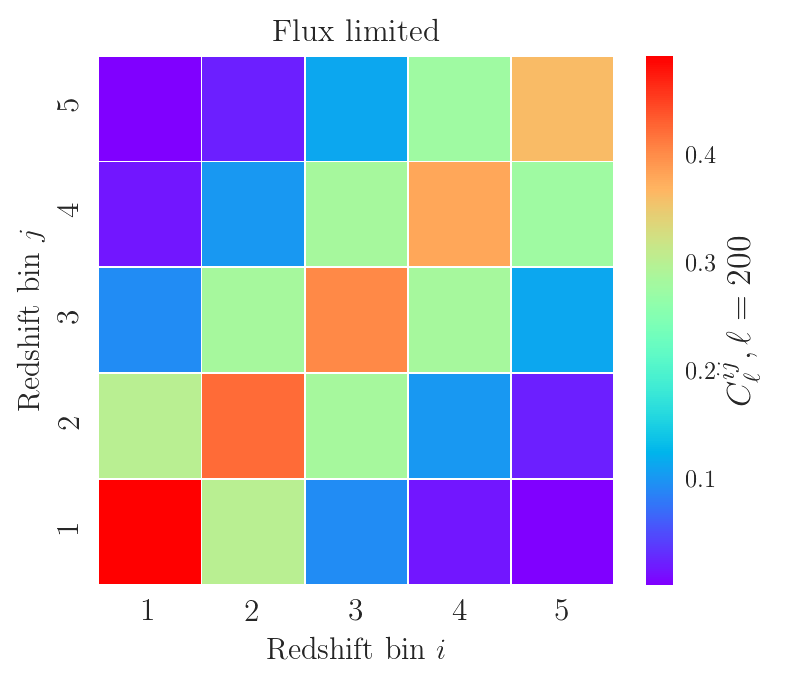

In [8]:
fig = plt.figure(figsize = (4.6,4.0))


ax = sns.heatmap(C_mat_fl/np.max(C_mat_rm), linewidths=.3,cmap="rainbow")
ax.invert_yaxis()
ax.collections[0].colorbar.set_label("$C_\ell^{ij}, \ell=200$", fontsize=14)

x_0 = [0.5,1.5,2.5,3.5,4.5]
y_0 =  [4.5,3.5,2.5,1.5,0.5]

labels = ['$1$', '$2$','$3$', '$4$', '$5$' ]

plt.xticks(x_0, labels, fontsize=13)
plt.yticks(y_0, labels, fontsize=13)

plt.xlabel('Redshift bin $i$', fontsize=12.5)
plt.ylabel('Redshift bin $j$', fontsize=12.5)



plt.title('Flux limited', fontsize=13)

plt.savefig('Cov_fl.pdf')
plt.tight_layout()
plt.show()

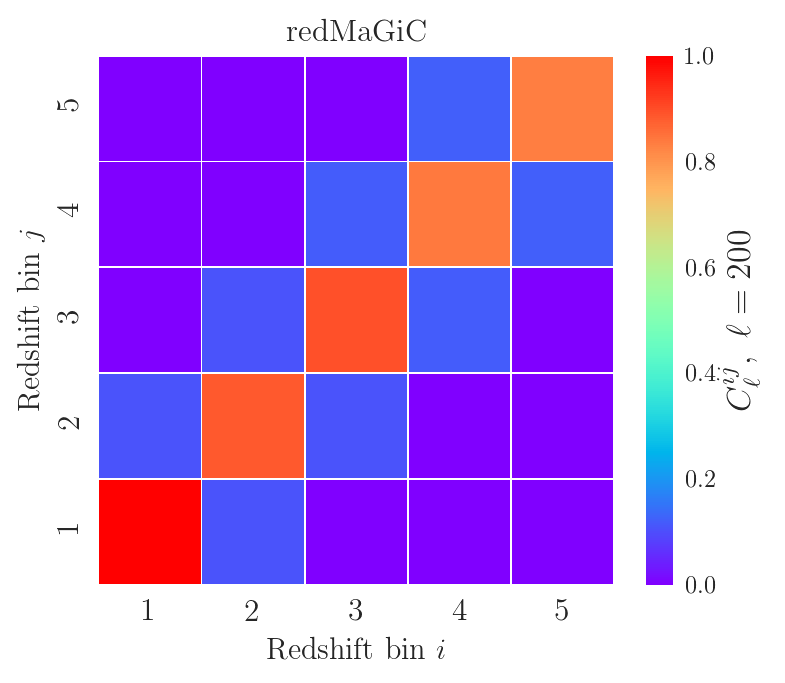

In [9]:
fig = plt.figure(figsize = (4.6,4.0))


ax = sns.heatmap(C_mat_rm/np.max(C_mat_rm), linewidths=.3,cmap="rainbow")
ax.invert_yaxis()
ax.collections[0].colorbar.set_label("$C_\ell^{ij}, \,\, \ell=200$", fontsize=14)

x_0 = [0.5,1.5,2.5,3.5,4.5]
y_0 =  [4.5,3.5,2.5,1.5,0.5]

labels = ['$1$', '$2$','$3$', '$4$', '$5$' ]

plt.xticks(x_0, labels, fontsize=13)
plt.yticks(y_0, labels, fontsize=13)

plt.xlabel('Redshift bin $i$', fontsize=12.5)
plt.ylabel('Redshift bin $j$', fontsize=12.5)


plt.title('redMaGiC', fontsize=13)

plt.savefig('Cov_rm.pdf')
plt.tight_layout()
plt.show()

In [10]:
print(sum_a_fl, sum_c_fl)

(1.3347744234254571e-05, 9.691582829268626e-06)


In [11]:
print(sum_a_rm, sum_c_rm)

(2.8872776200141905e-05, 2.991306966191824e-06)


In [12]:
print(sum_a_fl+sum_c_fl)
print(sum_a_rm+sum_c_rm)

2.3039327063523197e-05
3.186408316633373e-05


In [13]:
sum_a_fl_red = 0.0
sum_a_rm_red = 0.0

for i in range(5):
    n_b_rm = n_bin_rm[i]
    n_b_fl = n_bin_fl[i]
    
    sum_a_fl_red += C_mat_fl[i,i]/(C_mat_fl[i,i] + 1.0/(n_b_fl))
    sum_a_rm_red += C_mat_fl[i,i]/(C_mat_rm[i,i] + 1.0/(n_b_rm))

In [14]:
print(sum_a_fl_red)
print(sum_a_rm_red)

4.680919652056184
1.2891432377349408


In [15]:
C_mat_fl_red = np.copy(C_mat_fl)
C_mat_rm_red = np.copy(C_mat_rm)

for i in range(5):
    n_b_rm = n_bin_rm[i]
    n_b_fl = n_bin_fl[i]
    
    C_mat_fl_red[i,i] = C_mat_fl[i,i] + 1.0/(n_b_fl)
    C_mat_rm_red[i,i] = C_mat_rm[i,i] + 1.0/(n_b_rm)    

In [16]:
Cov_mat = np.zeros([25,25])

for i in range(5):
    for j in range(5):
        for m in range(5):
            for n in range (5):
                Cov_mat[i,n] = C_mat_fl_red[i,m]*C_mat_fl_red[j,n] + C_mat_fl_red[i,n]*C_mat_fl_red[j,m]
                
Cov_mat = np.copy(Cov_mat)*(1.0/((2.0*200+1)*f_sky))